# ISE 633 Homework 3 (coding part)

Author: Yue Wu <wu.yue@usc.edu>
$\def\vf#1{\boldsymbol{#1}}$

This notebook is the coding part of the third homework of ISE 633. It is written in a style where code and explanations are interleaved. The notebook is written in Python 3.12 and is best viewed in a Jupyter notebook environment.

### Dependencies

It requires the following packages:

```plain
jax==0.4.23
jaxtyping==0.2.25
beartype==0.17.2
equinox==0.11.3
```

and reasonably new versions of `seaborn`, `matplotlib` and `pandas`. The notebook is exclusively written in Python 3.12+. Since the computation is done with JAX with its fully deterministic RNGs, the results should be completely reproducible. The local dependencies (i.e. `utils.*`) will be available in the same directory as this notebook in my github [repository](https://github.com/EtaoinWu/ise633).

A significant portion of code in this notebook is identical to my previous homework.

In [1]:
from functools import partial

import beartype
import equinox as eqx
import ipytest
import jax
import jax.scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
from beartype.typing import Any, Callable, cast
from jax import numpy as jnp, random as jr
from jaxtyping import Array, Bool, Float, Integer, Key, Scalar, jaxtyped
from matplotlib.axes import Axes

import utils.platform

ipytest.autoconfig()
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_threefry_partitionable", True)

utils.platform.init_matplotlib("svg")
sns.set_theme("notebook", style="whitegrid")

SingleKey = Key[Scalar, ""]
typechecked = jaxtyped(typechecker=beartype.beartype)
FloatLike = float | Float[Scalar, ""]


def jconst(x) -> Float[Scalar, ""]:
    return jnp.array(x, dtype=float)

On different descent methods on a constrainedl quadratic optimization problem.

Generate the matrix $\vf Q$ and the vector $\vf b$ according to the procedure described in the problem.


In [2]:
class QuadraticOptimization(eqx.Module):
    Q: Float[Array, "n n"]
    b: Float[Array, " n"]

    @typechecked
    def __call__(self, x: Float[Array, " n"]) -> Float[Scalar, ""]:
        return 0.5 * x.T @ self.Q @ x + jnp.dot(self.b, x)

    @typechecked
    def satisfy_constraints(
        self, x: Float[Array, " n"]
    ) -> Bool[Scalar, ""]:
        return jnp.logical_and(x >= 0, x <= 1).all()

    @typechecked
    def project(self, x: Float[Array, " n"]) -> Float[Array, " n"]:
        return jnp.clip(x, 0, 1)


@typechecked
def generate_qd(
    key: SingleKey,
    n: int,
    diag_noise_scale_log: FloatLike,
    linear_noise_scale: FloatLike,
) -> QuadraticOptimization:
    B_key, D_key, b_key = jr.split(key, 3)
    B = jr.normal(B_key, (n, n))
    D_diag = jnp.exp(jr.normal(D_key, (n,)) + diag_noise_scale_log)
    D = jnp.diag(D_diag)
    Q = B @ B.T + D
    b = jr.normal(b_key, (n,)) * linear_noise_scale
    return QuadraticOptimization(Q, b)


@typechecked
def condition_number(Q: Float[Array, "n n"]) -> Float[Scalar, ""]:
    return jnp.linalg.cond(Q)


@typechecked
def spectral_radius(Q: Float[Array, "n n"]) -> Float[Scalar, ""]:
    """
    Spectral radius of a symmetric real matrix Q.
    """
    return jnp.max(jnp.abs(jnp.linalg.eigvalsh(Q)))

In [3]:
instance_key = jr.key(20240226)
n = 100
qd_instance = generate_qd(instance_key, n, 0.0, 10.0)
lipschitz = spectral_radius(qd_instance.Q)
print(
    f"Condition number: {condition_number(qd_instance.Q)}, "
    f"lipschitz constant: {lipschitz}"
)

Condition number: 317.0526034227108, lipschitz constant: 383.7938632238674


### Implementation of algorithms

Implement classical gradient descent algorithm with these step-size selection rules:

- Diminishing step-size rule $α^r = {5 \log{r}\over rL}$ where $L$ is the Lipschitz constant of the gradient of the objective function.
- Constant step-size rule $α^r = {1\over L}$.


In [4]:
StepSizeType = FloatLike | Callable[[Integer[Scalar, ""]], FloatLike]


@typechecked
def log_step_size(
    t: Integer[Scalar, ""], c: Float[Scalar, ""]
) -> Float[Scalar, ""]:
    return jnp.log(t) / t * c


@typechecked
def power_step_size(
    t: Integer[Scalar, ""], p: Float[Scalar, ""], c: Float[Scalar, ""]
) -> Float[Scalar, ""]:
    return t**-p * c


@typechecked
def descent_step(
    x: Float[Array, " n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    extra: None | Integer[Scalar, ""] = None,
    /,
    stepsize: StepSizeType = jconst(1),
) -> tuple[Float[Array, " n"], Integer[Scalar, ""]]:
    t = jnp.array(1, dtype=int) if extra is None else extra
    direc = -jax.grad(fun)(x)
    stepsize = stepsize(t) if callable(stepsize) else stepsize
    return (x + stepsize * direc, t + 1)

### Main descent framework

In [5]:
Extra = Any | None
StepFunction = Callable[
    [
        Float[Array, " n"],
        Callable[[Float[Array, " n"]], Float[Scalar, ""]],
        Extra,
    ],
    Float[Array, " n"] | tuple[Float[Array, " n"], Extra],
]
ProjectionFunction = Callable[[Float[Array, " n"]], Float[Array, " n"]]

Carry = tuple[Float[Array, " n"], Extra]
Output = tuple[Float[Array, " n"], Float[Scalar, ""]]


@partial(jax.jit, static_argnums=[3], static_argnames=["max_iter"])
@typechecked
def descent(
    x0: Float[Array, "n"],
    fun: Callable[[Float[Array, " n"]], Float[Scalar, ""]],
    proj: ProjectionFunction,
    step: StepFunction,
    /,
    max_iter: int = 100,
    extra0: None = None,
) -> tuple[Float[Array, "m n"], Float[Scalar, " m"]]:
    @jax.jit
    @typechecked
    def iter(carry: Carry, input: None) -> tuple[Carry, Output]:
        x, extra = carry
        new = step(x, fun, extra)
        if isinstance(new, tuple):
            new_x, new_extra = new
        else:
            new_x, new_extra = new, extra
        new_x = proj(new_x)
        return (new_x, new_extra), (x, fun(x))

    (x1, extra1), (x0, f0) = iter((x0, extra0), None)
    cn, os = jax.lax.scan(iter, (x1, extra1), None, length=max_iter - 1)
    xs, fs = os
    return jnp.concatenate([x0[None, :], xs]), jnp.concatenate(
        [f0[None], fs]
    )

### Experiment

Running Diminishing step
Running Constant step


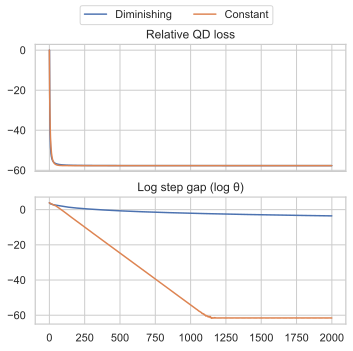

In [6]:
test_setups = [
    (
        "Diminishing",
        partial(
            descent_step,
            stepsize=partial(log_step_size, c=jconst(5 / lipschitz)),
        ),
    ),
    ("Constant", partial(descent_step, stepsize=jconst(1 / lipschitz))),
]


def step_gap(
    x: Float[Array, "n"],
    fun: Callable[[Float[Array, "n"]], Float[Scalar, ""]],
    proj: Callable[[Float[Array, "n"]], Float[Array, "n"]],
) -> Float[Scalar, ""]:
    return jnp.linalg.norm(x - proj(x - jax.grad(fun)(x))) ** 2


def run_plot(test_setups, func, proj, max_iter: int = 1000):
    plt.ioff()
    fig, axs = plt.subplots(
        2, 1, figsize=(4.8, 4.8), sharex=True, layout="constrained"
    )
    axs = cast(list[Axes], list(axs.flatten()))
    ax1, ax2 = axs
    ax1.set_title("Relative QD loss")
    ax2.set_title("Log step gap (log θ)")

    for name, step in test_setups:
        print(f"Running {name} step")
        xs, fs = descent(
            jnp.zeros(n), func, proj, step, max_iter=max_iter
        )
        ax1.plot(fs, label=name)
        log_step_gap = jnp.log(
            jax.vmap(step_gap, (0, None, None))(xs, func, proj)
        )
        ax2.plot(log_step_gap, label=name)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="outside upper center", ncol=3)
    plt.show()


run_plot(test_setups, qd_instance, qd_instance.project, max_iter=2000)

We can see that the constant step-size rule converges faster than the diminishing step-size rule. The diminishing step-size rule converges to essentially the machine precision.